In [1]:
import pickle
from pathlib import Path
import numpy as np
import gurobipy as gp; gp.Model()

from src.input import Input_uc, Input_ed
from src.output import Output_uc, Output_ed
from src.unit_commitment import solve_uc, solve_uc_snapshot
from src.economic_dispatch import solve_ed
from src.plot import plot_schedule_heatmap

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [2]:
def load_data():
    path_folder_processed = Path.cwd() / "data" / "input" / "processed"
    timestamp_2022 = np.load(path_folder_processed / "timestamp_2022.npy")
    
    global num_units, num_periods, time_start
    num_units = 122
    num_periods = 24
    time_start, time_end = np.datetime64("2022-07-02T00"), np.datetime64("2022-07-02T23")
    # time_start, time_end = np.datetime64("2022-07-02T00"), np.datetime64("2022-07-02T23")
    idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]

    global unit_type, idx_nuclear, idx_coal, idx_lng
    unit_type = np.load(path_folder_processed / "unit_type.npy")
    idx_nuclear = np.load(path_folder_processed / "idx_nuclear.npy")
    idx_coal = np.load(path_folder_processed / "idx_coal.npy")
    idx_lng = np.load(path_folder_processed / "idx_lng.npy")

    global p_min, p_max, ramp_up, ramp_down, startup_ramp, shutdown_ramp, min_up, min_down
    p_min = np.load(path_folder_processed / "p_min.npy")
    p_max = np.load(path_folder_processed / "p_max.npy")
    ramp_up = np.load(path_folder_processed / "ramp_up.npy")
    ramp_down = np.load(path_folder_processed / "ramp_down.npy")
    startup_ramp = np.load(path_folder_processed / "startup_ramp.npy")
    shutdown_ramp = np.load(path_folder_processed / "shutdown_ramp.npy")
    min_up = np.load(path_folder_processed / "min_up.npy")
    min_down = np.load(path_folder_processed / "min_down.npy")

    global cost_lin, cost_const, cost_startup_step_old, num_cooling_steps_old, cost_startup_step, step_length
    cost_lin = np.load(path_folder_processed / "cost_lin.npy")
    cost_const = np.load(path_folder_processed / "cost_const.npy")
    cost_startup_step_old = pickle.load(open(path_folder_processed / "cost_startup_step_old.pkl", "rb"))
    num_cooling_steps_old = np.load(path_folder_processed / "num_cooling_steps_old.npy")
    cost_startup_step = np.load(path_folder_processed / "cost_startup_step.npy")
    step_length = np.load(path_folder_processed / "step_length.npy")

    global demand, renewable
    demand = np.load(path_folder_processed / "demand_2022.npy")[idx_time_start:idx_time_end+1]
    renewable = np.load(path_folder_processed / "renewable_gen_2022.npy")[idx_time_start:idx_time_end+1]

    global p_prev, u_prev, min_up_r, min_down_r, min_up_0, min_down_0
    p_prev = np.load(path_folder_processed / "p_prev.npy")
    u_prev = np.load(path_folder_processed / "u_prev.npy")
    min_up_r = np.load(path_folder_processed / "min_up_r.npy")
    min_down_r = np.load(path_folder_processed / "min_down_r.npy")
    min_up_0 = np.load(path_folder_processed / "min_up_0.npy")
    min_down_0 = np.load(path_folder_processed / "min_down_0.npy")

    # test kpg renewable   # with KPG renewable you cannot turn on all units  because pmin sum exceeds the net load so yeah
    # renewable = np.load(path_folder_processed / "renewable_gen_2022_kpg.npy")[idx_time_start:idx_time_end+1]

In [3]:
load_data()

**Q2 FULL UC + FULL ED**

In [4]:
input_uc = Input_uc(
    # meta
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods,
    # system
    demand=demand,
    reserve=np.zeros(num_periods),
    renewable=renewable,
    # generator
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # cost function - generation
    cost_lin=cost_lin,
    cost_const=cost_const,
    # cost function - startup (paper formulation)
    cost_startup_step=cost_startup_step,
    step_length=step_length,
    # cost function - startup (lecture note formulation)
    cost_startup_step_old=cost_startup_step_old,
    num_cooling_steps_old=num_cooling_steps_old,
    # initial conditions
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

In [5]:
# Q2 UC + ED (temporal constraints; basically resolved inside solve_uc by recursive call with fixed binaries)
output_uc = Output_uc()
solve_uc(input_uc=input_uc, output_uc=output_uc, verbose=True)

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 34942 rows, 23424 columns and 133135 nonzeros
Model fingerprint: 0x8de17af4
Variable types: 5856 continuous, 17568 integer (17568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+03, 6e+07]
  Bounds range     [1e+00, 7e+02]
  RHS range        [1e+00, 7e+04]
Presolve removed 23469 rows and 

**Q1 FULL UC + SNAPSHOT ED**

In [6]:
input_ed = Input_ed(
    u = output_uc.u,
    # meta
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods,
    # system
    demand=demand,
    reserve=np.zeros(num_periods),
    renewable=renewable,
    # generator
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # cost function - generation
    cost_lin=cost_lin,
    cost_const=cost_const,
    # cost function - startup (paper formulation)
    cost_startup_step=cost_startup_step,
    step_length=step_length,
    # cost function - startup (lecture note formulation)
    cost_startup_step_old=cost_startup_step_old,
    num_cooling_steps_old=num_cooling_steps_old,
    # initial conditions
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

In [7]:
# Q1 UC + ED (no temporal constraints)

output_ed_all = []
for t in range(num_periods):
    
    output_ed = Output_ed()
    solve_ed(input_ed, output_ed, t, True)
    output_ed_all.append(output_ed)

# output uc construction for heatmap plot and data indexing with t
output_ed_after_uc = Output_uc()

output_ed_after_uc.u = output_uc.u
output_ed_after_uc.p = np.empty((num_units, num_periods))
for t in range(num_periods):
    output_ed_after_uc.p[:, t] = output_ed_all[t].p
output_ed_after_uc.cost_generation = np.array([output_ed_all[t].cost_generation for t in range(num_periods)])
output_ed_after_uc.total_cost_generation = output_ed_after_uc.cost_generation.sum()
output_ed_after_uc.marginal_price_generation = np.array([output_ed_all[t].marginal_price_generation for t in range(num_periods)])

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-09
IntFeasTol  1e-09
MIPGap  0
MIPGapAbs  0
OptimalityTol  1e-09

Optimize a model with 1 rows, 122 columns and 122 nonzeros
Model fingerprint: 0xba74870c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+03, 7e+04]
  Bounds range     [4e+01, 1e+03]
  RHS range        [7e+04, 7e+04]
Presolve removed 0 rows and 117 columns
Presolve time: 0.00s
Presolved: 1 rows, 5 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0  

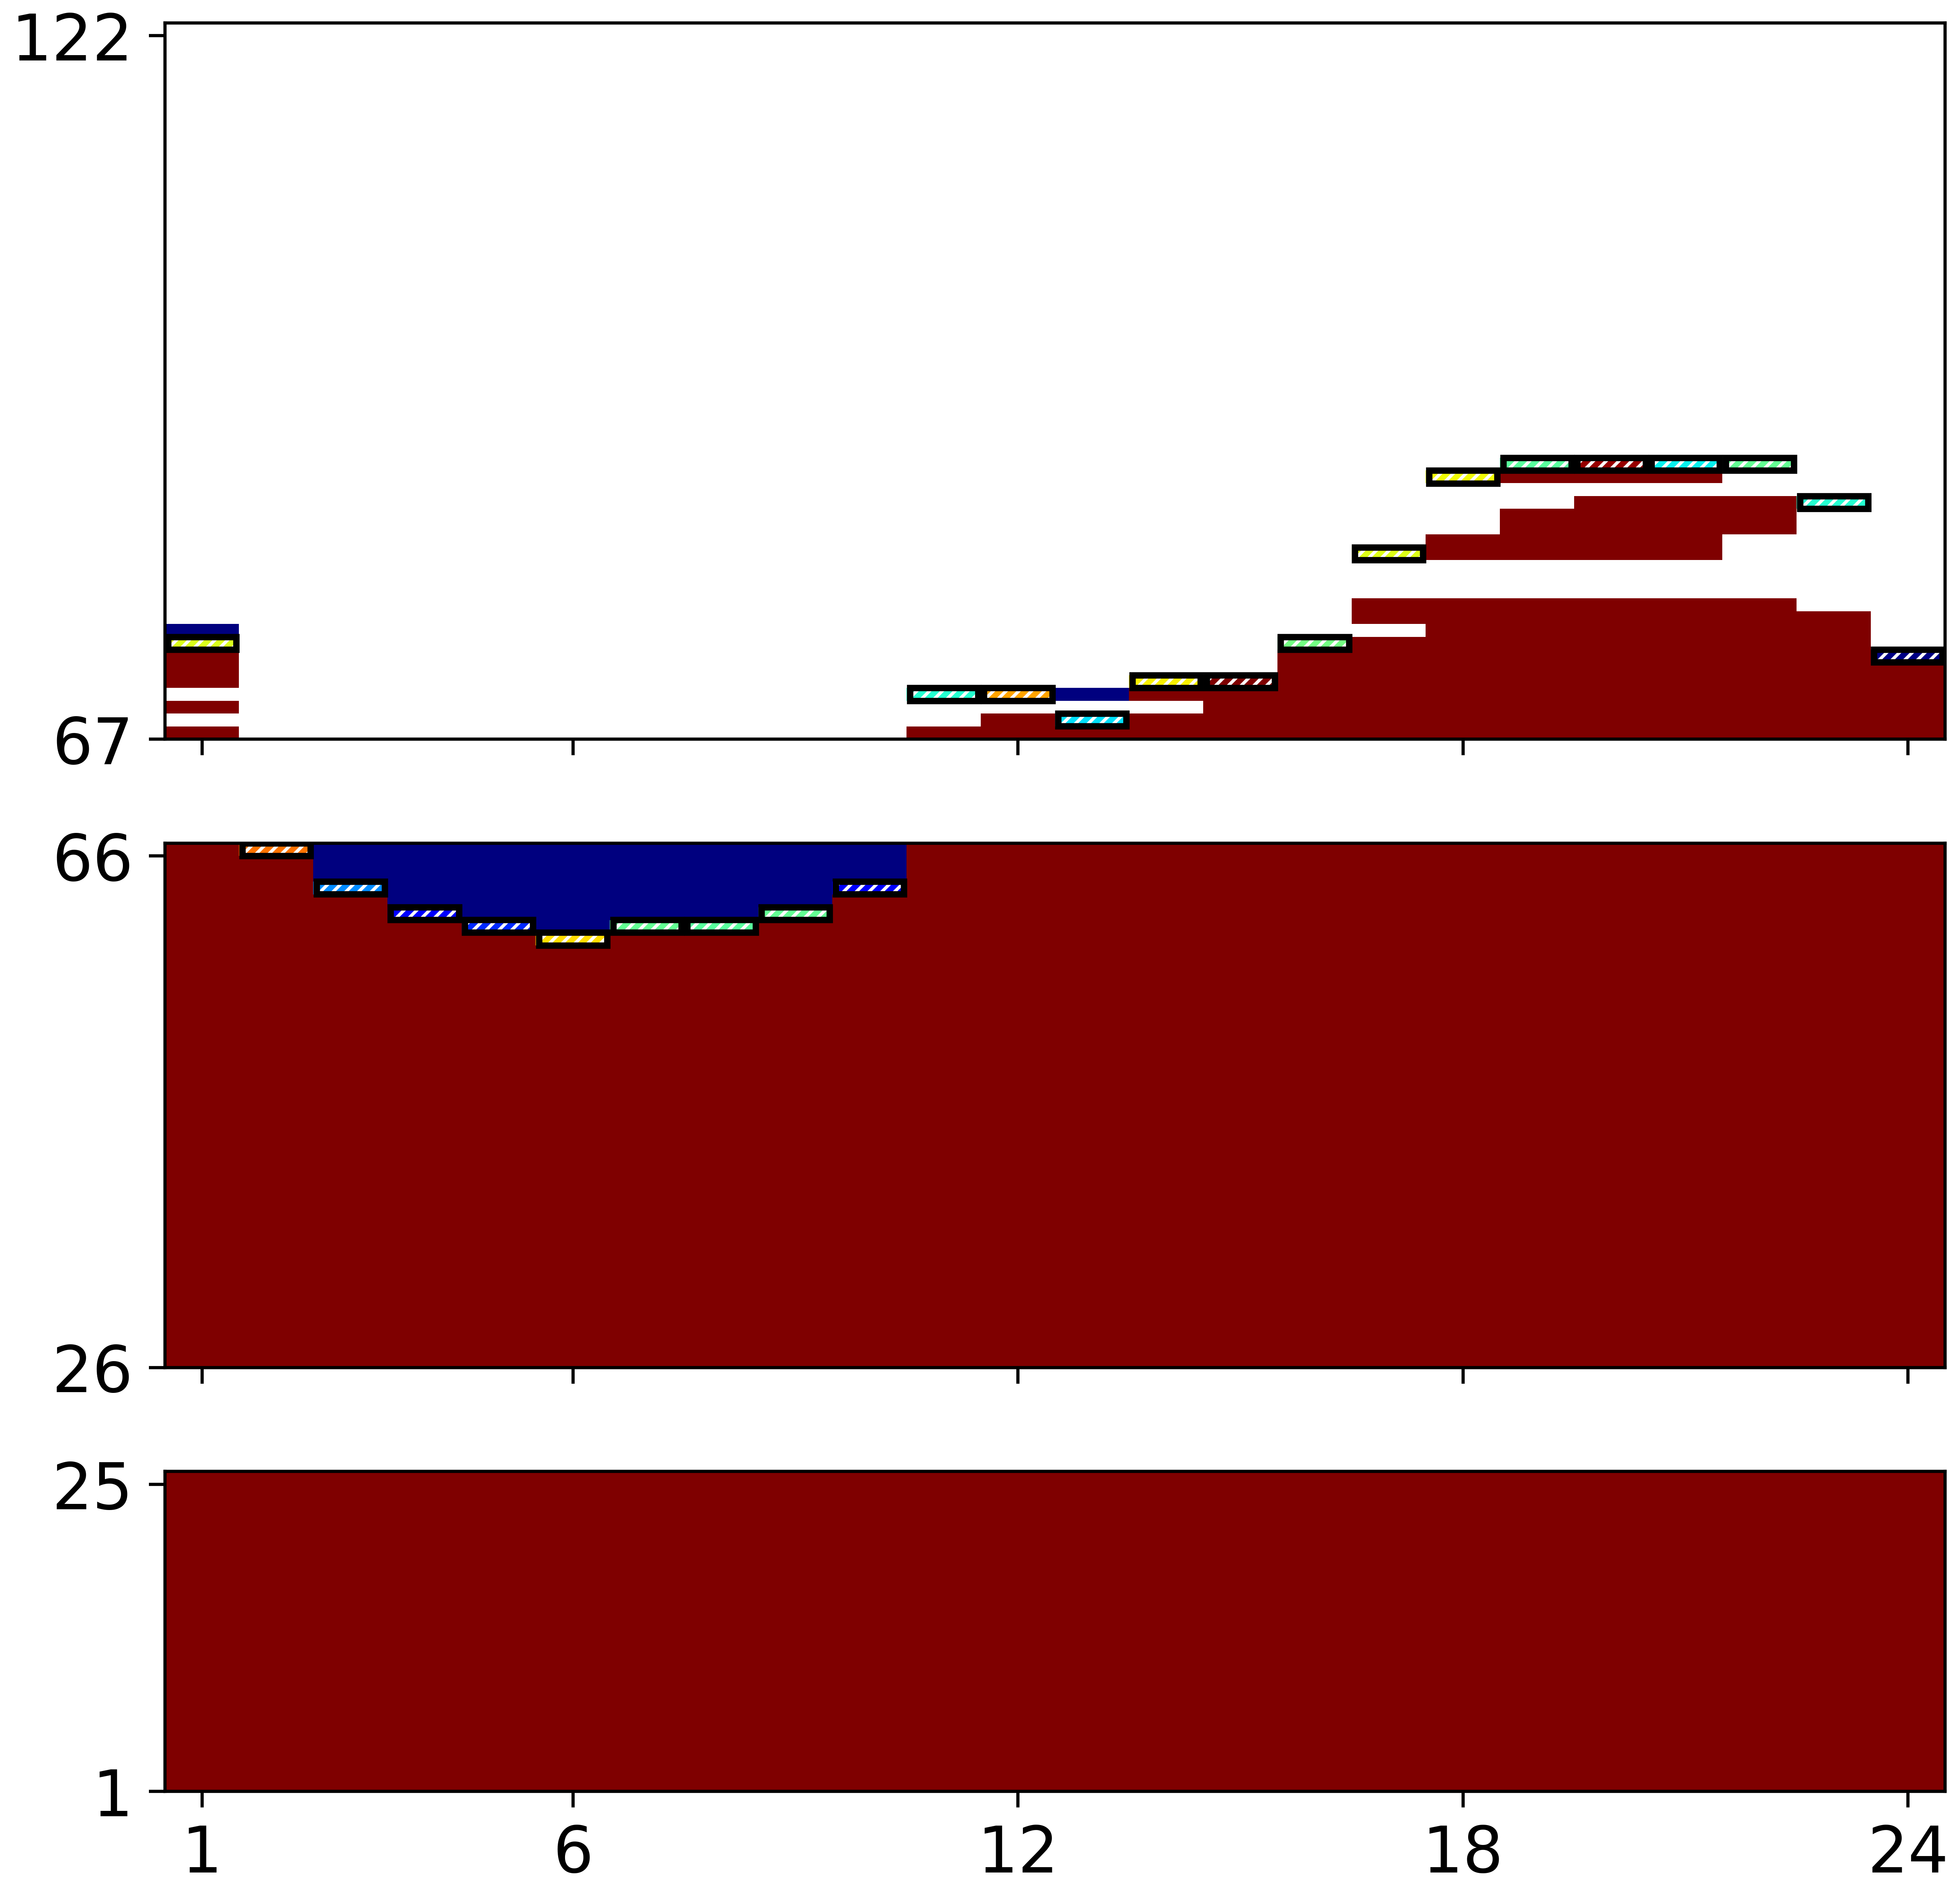

In [8]:
_ = plot_schedule_heatmap(input_uc=input_uc, output_uc=output_ed_after_uc)

In [9]:
(output_uc.p - output_ed_after_uc.p).max() # it is the same; no ramp constraint bound here 
# ED (no temproal constraints) vs ED ( temporal cosntraints) deviation not recorded. i also tested up to renewable x20 but no
# with KPG its showing  because the renewable is high and also its longer

np.float64(1.716671249596402e-11)

In [10]:
# With other timeseries data, it is possible to observe diverse patterns. part in the report

# the test KPG renewable uncommented in load_data then run this, the 18th hour coal torquoise one is this unit
# we can also just check my ramp = model.addConst.... then check the slack being 0 for this unit and time
print(output_uc.p[idx_coal[-5], 17])
print(input_uc.p_min[idx_coal[-5]])
print(input_uc.p_min[idx_coal[-5]])
print(input_uc.startup_ramp[idx_coal[-5]])
# lng minup
print(min_up[idx_lng])

1000.0
400.0
400.0
660.0
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


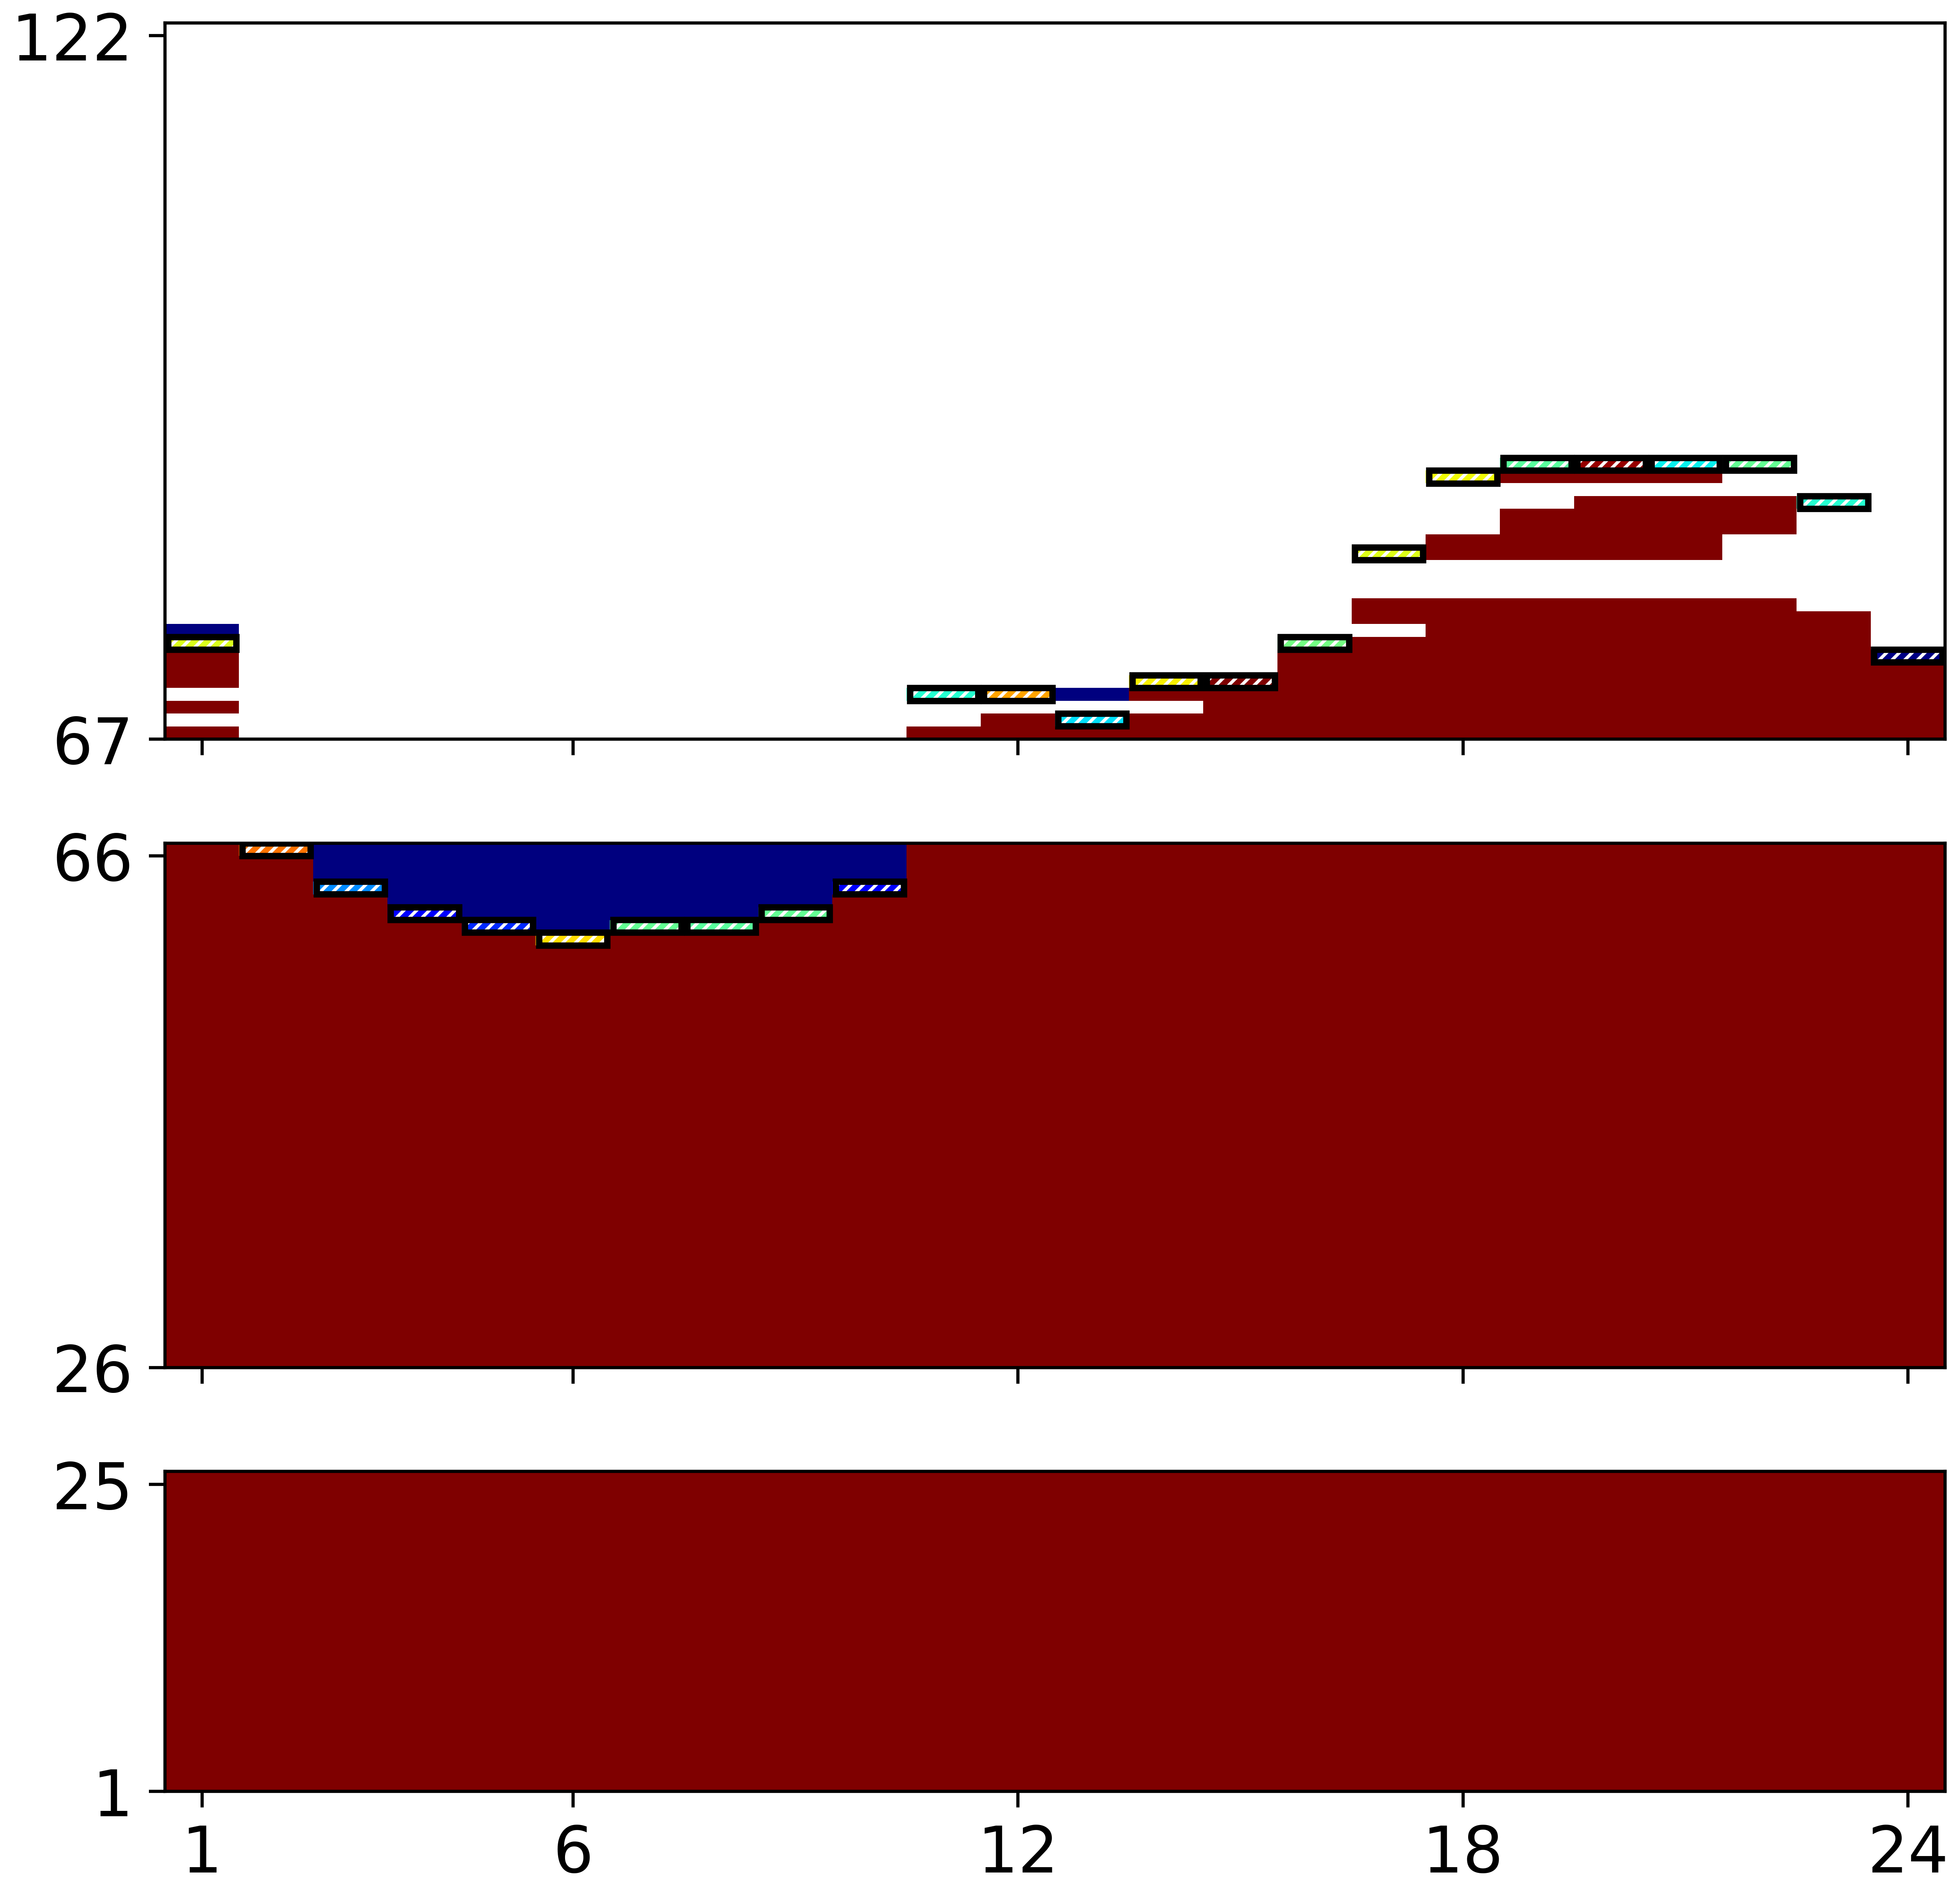

In [11]:
# question 2's plot (UC + ED but with ramp and inter termporal constraints (which was basically binary fix recursive call))
_ = plot_schedule_heatmap(input_uc=input_uc, output_uc=output_uc)

**Q1 ED-only** (no temporal constraints)

TURN ON ALL UNITS (it was possible; sum(p_min) < demand - renewable)

In [12]:
input_ed_only_case_1 = Input_ed(
    u = np.ones((num_units, num_periods), dtype=np.int64), ###### turned on everything
    # meta
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods,
    # system
    demand=demand,
    reserve=np.zeros(num_periods),
    renewable=renewable,
    # generator
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # cost function - generation
    cost_lin=cost_lin,
    cost_const=cost_const,
    # cost function - startup (paper formulation)
    cost_startup_step=cost_startup_step,
    step_length=step_length,
    # cost function - startup (lecture note formulation)
    cost_startup_step_old=cost_startup_step_old,
    num_cooling_steps_old=num_cooling_steps_old,
    # initial conditions
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

In [13]:
# Q1 ED-only (no temporal constraints)

output_ed_all = []
for t in range(num_periods):
    
    output_ed = Output_ed()
    solve_ed(input_ed_only_case_1, output_ed, t, False)
    output_ed_all.append(output_ed)


# output uc construction for heatmap plot and data indexing with t
output_ed_only_case_1 = Output_uc()

output_ed_only_case_1.u = input_ed_only_case_1.u
output_ed_only_case_1.p = np.empty((num_units, num_periods))
for t in range(num_periods):
    output_ed_only_case_1.p[:, t] = output_ed_all[t].p
output_ed_only_case_1.cost_generation = np.array([output_ed_all[t].cost_generation for t in range(num_periods)])
output_ed_only_case_1.total_cost_generation = output_ed_only_case_1.cost_generation.sum()
output_ed_only_case_1.marginal_price_generation = np.array([output_ed_all[t].marginal_price_generation for t in range(num_periods)])

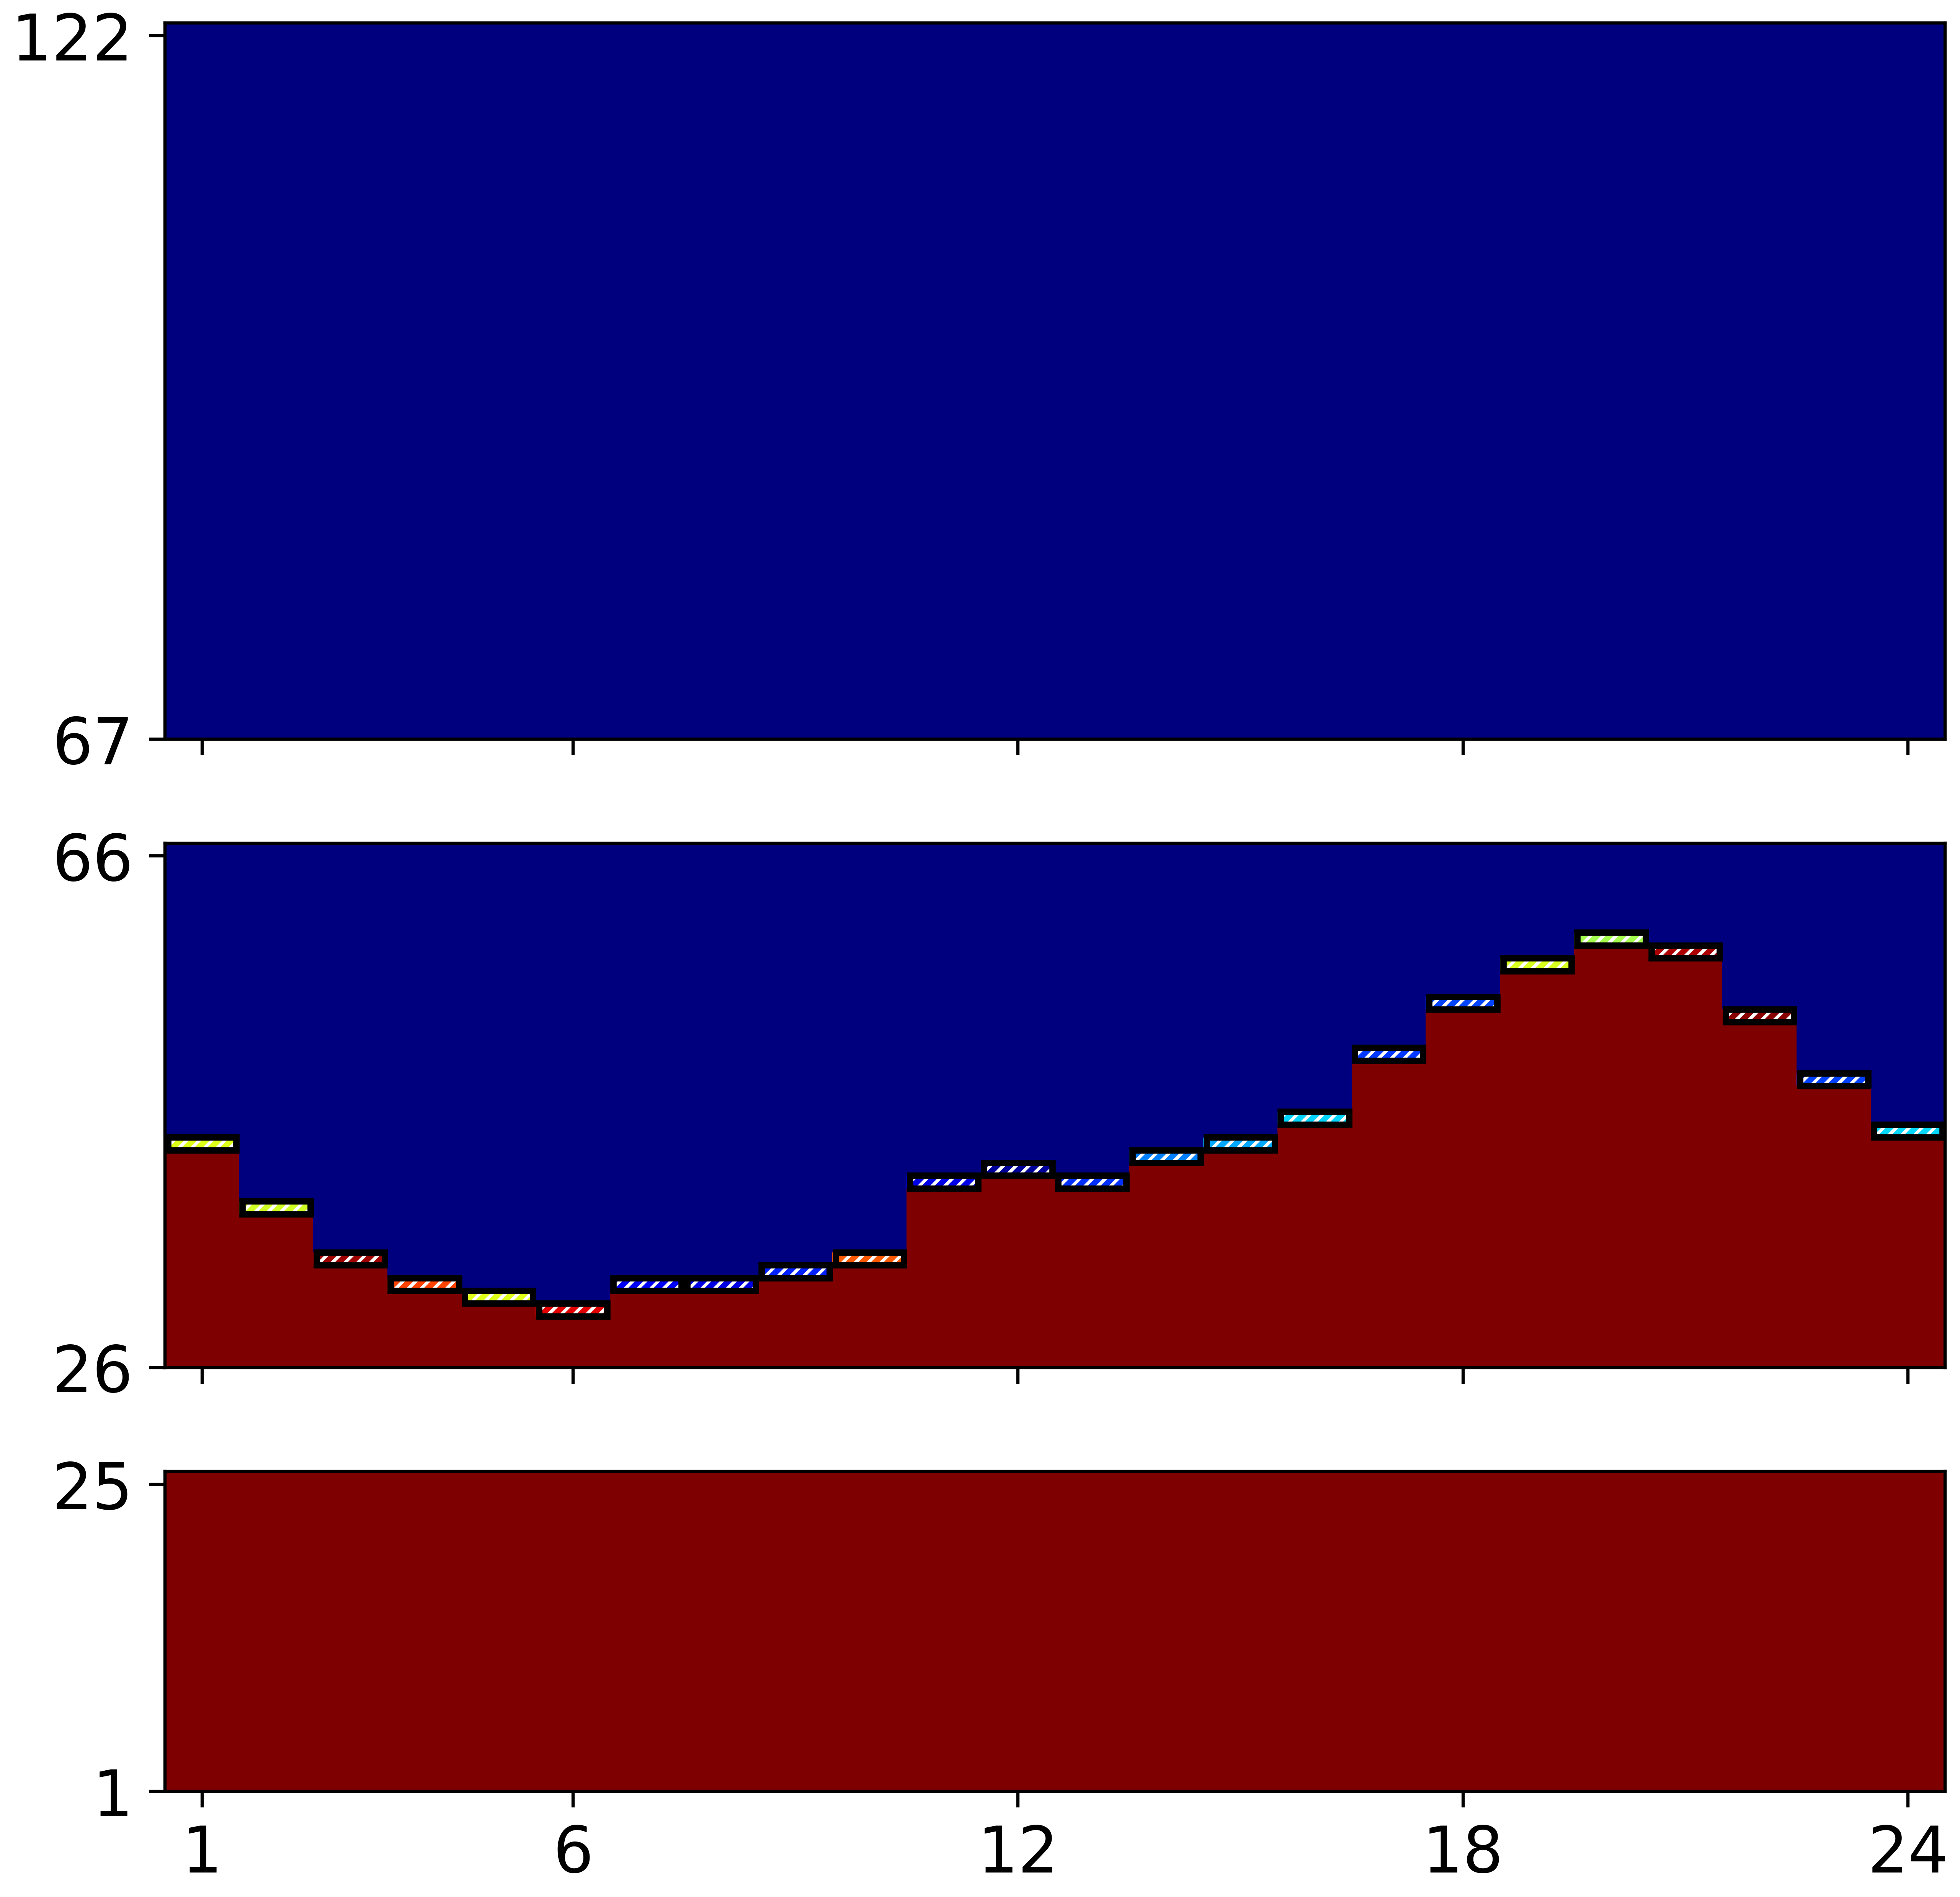

In [14]:
_ = plot_schedule_heatmap(input_uc=input_ed_only_case_1, output_uc=output_ed_only_case_1)

**Q1 ED-only** (no temporal constraints)

SOME UNITS ARE ON

LOGIC: TURN ON ONE BY ONE LOWEST COST LIN, RESIDUE LOAD < P_MIN THEN SKIP

In [15]:
thermal_demand = demand - renewable
# WE DON'T NEED TO CHECK FOR THIS CASE
# EX) ONE IS SKIPPED BC RESIDUE WAS LESS THAN THE UNIT'S PMIN
# NEXT UNIT WASN'T MARGINAL CUS ITS PMAX > RESIDUE
# NEW RESIDUE < OLD RESIDUE
# DO WE HAVE TO GO BACK TO SKIPPED UNIT? NO , NEW RESIDUE < OLD_RESIDUE < SKIPPED UNITS' PMIN

u = np.zeros((num_units, num_periods), dtype=np.int64)
for t, td in enumerate(thermal_demand):
    resid = td
    u_t = np.zeros(num_units, dtype=np.int64)
    skipped = []

    for i in range(num_units):
        if resid <= 0:
            break

        pmn, pmx = p_min[i], p_max[i]

        if resid > pmx:
            u_t[i] = 1
            resid -= pmx
        else:
            if resid >= pmn:
                u_t[i] = 1
                resid = 0
                break
            else:
                skipped.append(i)

    if resid > 0 and skipped:
        i = skipped[0]
        u_t[i] = 1
        resid = 0

    u[:, t] = u_t

In [16]:
# True True -> the commitment decision is valid 
# all on units's pmin pmax sum vs thermal demand
print(np.all(np.array([p_max[u[:, t].astype(bool)].sum() >= thermal_demand[t] for t in range(num_periods)])))
print(np.all(np.array([p_min[u[:, t].astype(bool)].sum() <= thermal_demand[t] for t in range(num_periods)])))

True
True


In [17]:
input_ed_only_case_2 = Input_ed(
    u=u, # above
    # meta
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods,
    # system
    demand=demand,
    reserve=np.zeros(num_periods),
    renewable=renewable,
    # generator
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # cost function - generation
    cost_lin=cost_lin,
    cost_const=cost_const,
    # cost function - startup (paper formulation)
    cost_startup_step=cost_startup_step,
    step_length=step_length,
    # cost function - startup (lecture note formulation)
    cost_startup_step_old=cost_startup_step_old,
    num_cooling_steps_old=num_cooling_steps_old,
    # initial conditions
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

In [18]:
# Q1 ED-only (no temporal constraints)

output_ed_all = []
for t in range(num_periods):
    
    output_ed = Output_ed()
    solve_ed(input_ed_only_case_2, output_ed, t, False)
    output_ed_all.append(output_ed)


# output uc construction for heatmap plot and data indexing with t
output_ed_only_case_2 = Output_uc()

output_ed_only_case_2.u = input_ed_only_case_2.u
output_ed_only_case_2.p = np.empty((num_units, num_periods))
for t in range(num_periods):
    output_ed_only_case_2.p[:, t] = output_ed_all[t].p
output_ed_only_case_2.cost_generation = np.array([output_ed_all[t].cost_generation for t in range(num_periods)])
output_ed_only_case_2.total_cost_generation = output_ed_only_case_2.cost_generation.sum()
output_ed_only_case_2.marginal_price_generation = np.array([output_ed_all[t].marginal_price_generation for t in range(num_periods)])

In [19]:
# # case 2 index 44
# # we can see that before 44th idx_lng unit the pmin was higher (376.2 > 209)
# # the residue was between 209 and 376.2
# print("lng's p at hour 11")
# print(output_ed_only_case_2.p[idx_lng, 11])
# print("lng's p_min")
# print(p_min[idx_lng])
# print()
# print("find that marginal the 209 one")
# print(np.where(p_min[idx_lng] == 209)[0][0])
# print("see if it matches (the 0th one have p 110 so it will be shown)")
# print(np.where((output_ed_only_case_2.p[idx_lng, 11] <= 289.98997387) & (output_ed_only_case_2.p[idx_lng, 11] > 0))[0])

In [20]:
# case 2 note
# p_min[idx_lng][5:7], p_max[idx_lng][5:7]
# cost_const[idx_lng][5:7], cost_lin[idx_lng][5:7]
# output_ed_only_case_2.p[idx_lng, 0][5:7]
# cost_lin[66+ 5], 66+ 5
# (
#     2490571.218 + 48005.64815 * 397.60281408
#     + 2515771.388 + 48491.38028 * 167.2
# )
# output_ed_only_case_2.marginal_price_generation

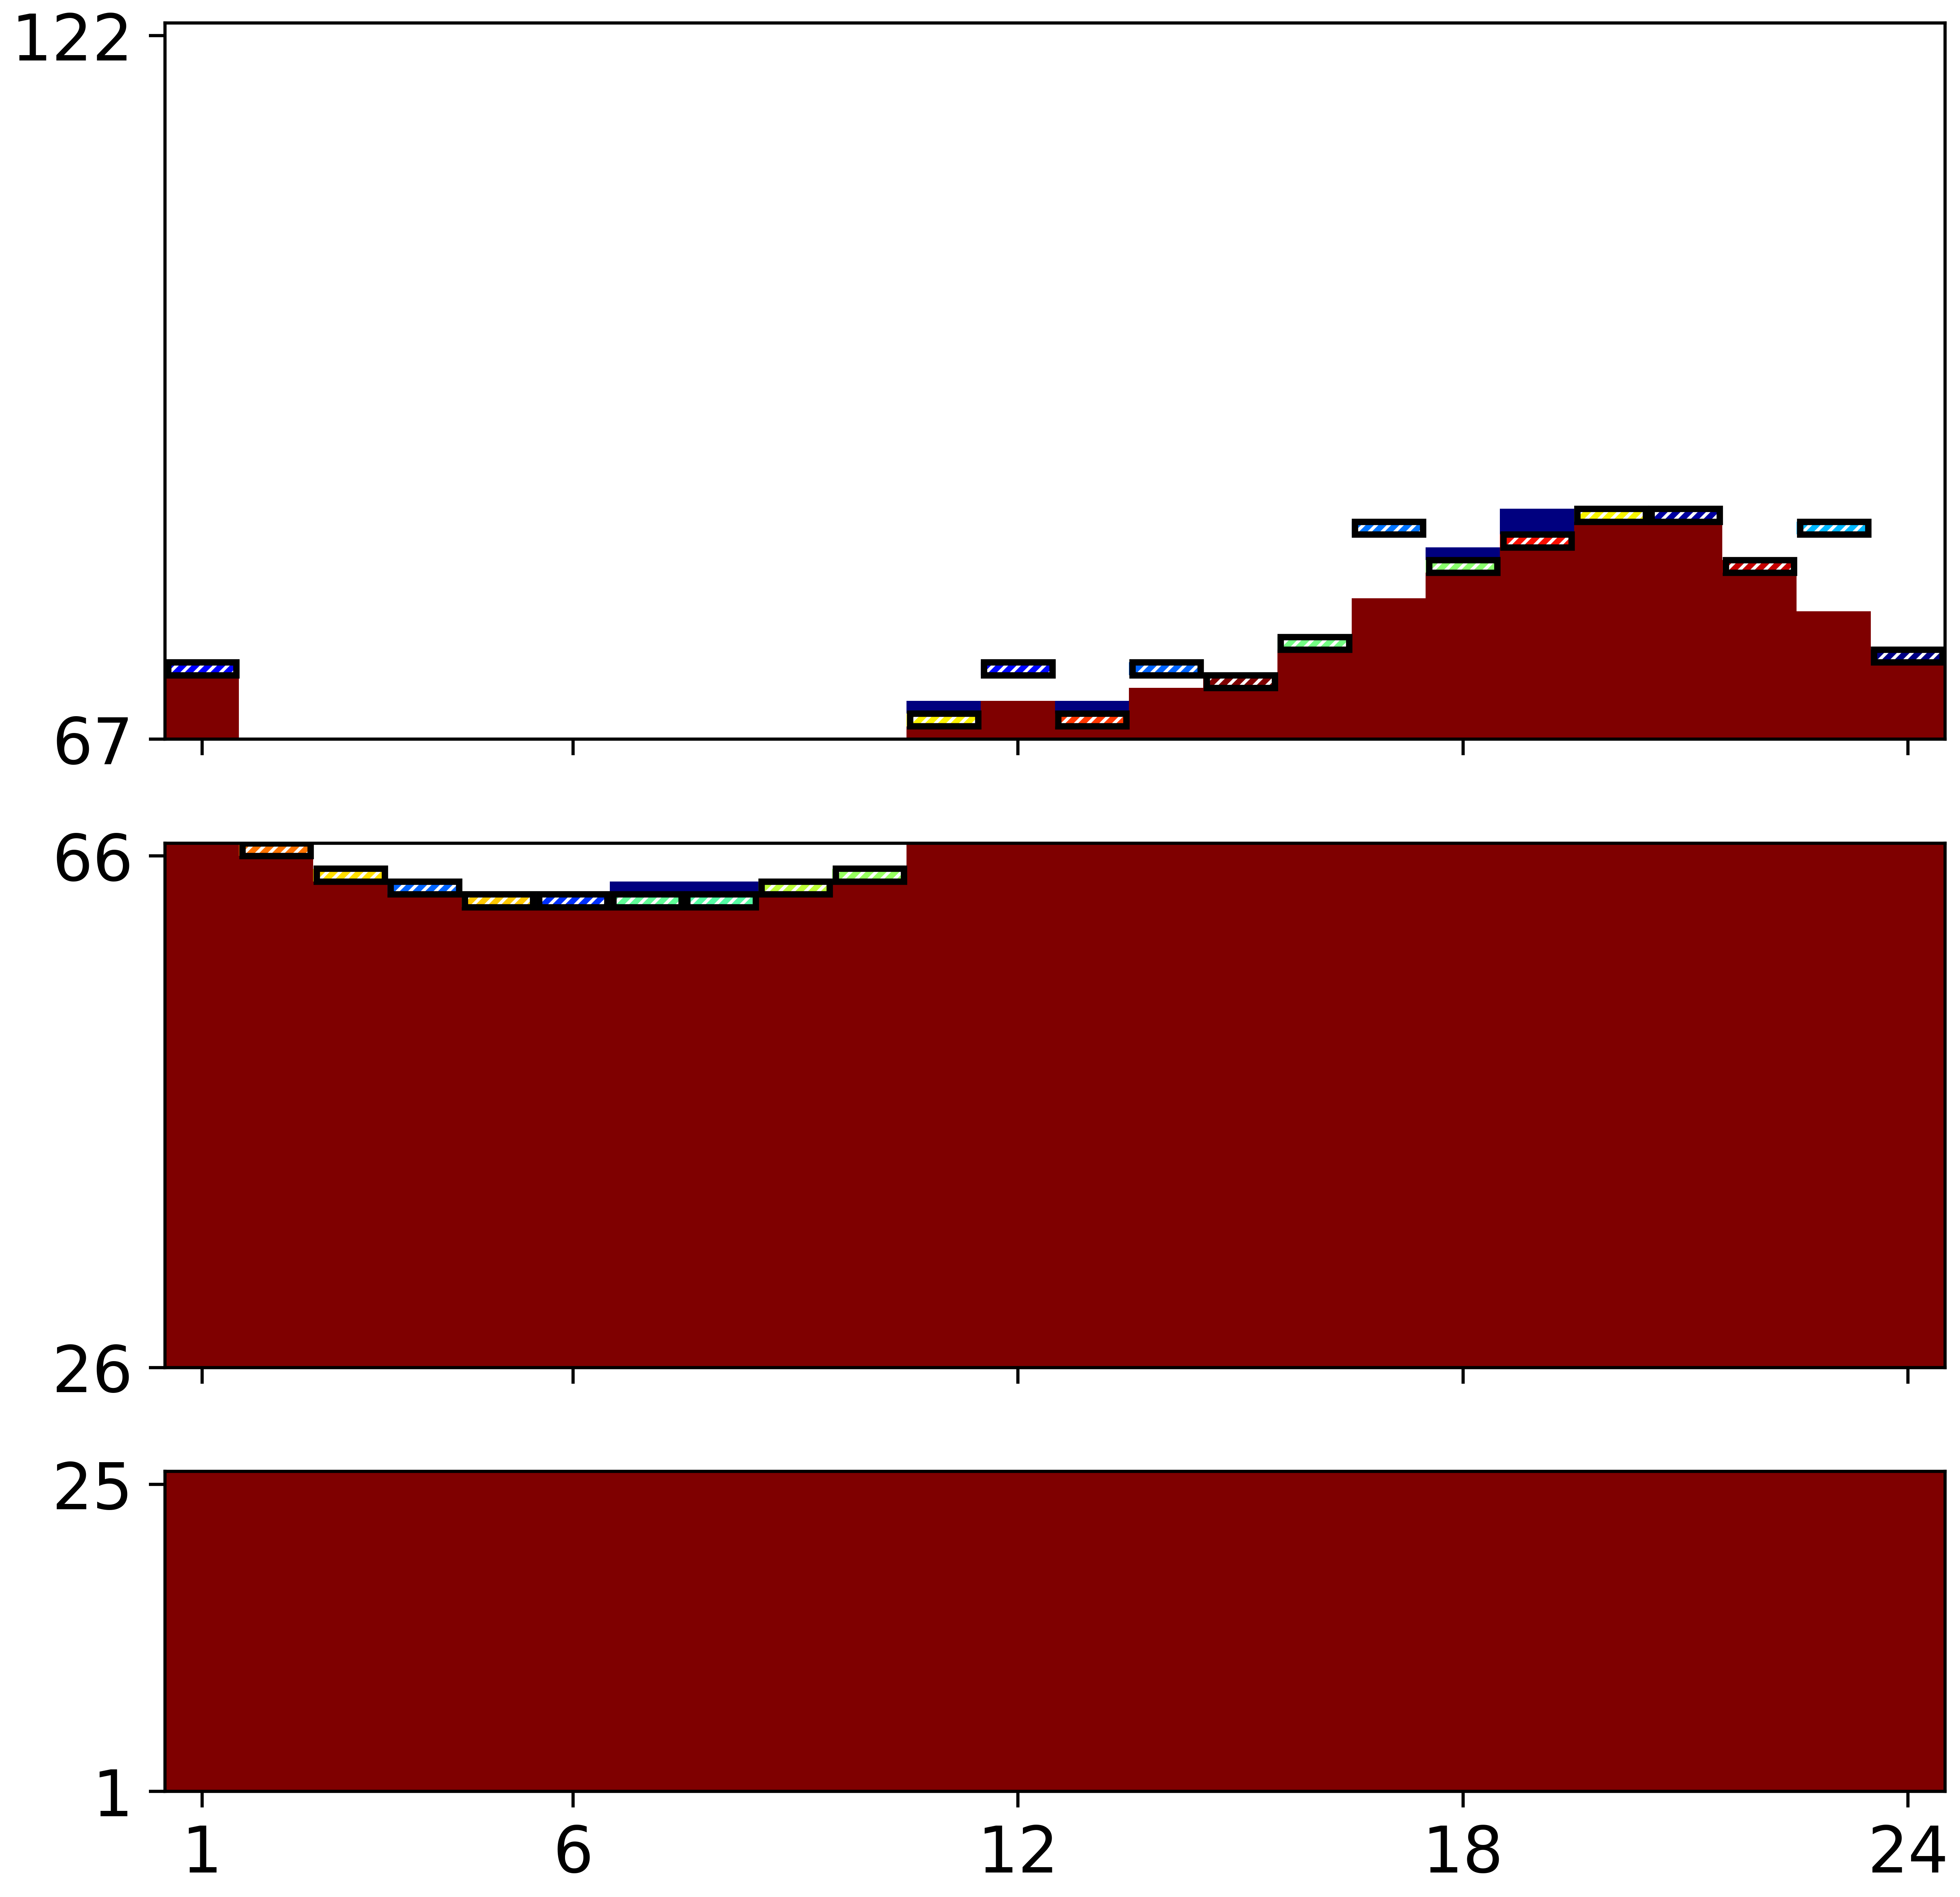

In [21]:
_ = plot_schedule_heatmap(input_uc=input_ed_only_case_2, output_uc=output_ed_only_case_2)

In [22]:
output_ed_only_case_2.marginal_price_generation - output_ed_after_uc.marginal_price_generation

array([-523.47938,    0.     ,   10.71025,  137.83461,  332.16695,
        379.31811,  332.16695,  332.16695,  137.83461,   10.71025,
       -286.12566,  468.96785,    0.     ,  148.83805,    0.     ,
          0.     ,  120.63203, -508.96814, -475.67437, -326.58332,
       -326.58332, -671.33964, -163.81229,    0.     ])

In [23]:
(output_ed_only_case_2.cost_generation - output_ed_after_uc.cost_generation)[8:12], (output_ed_only_case_2.cost_generation - output_ed_after_uc.cost_generation)[[17, 19]]

(array([-6841693.15504098, -4583182.84980011,  -153625.88572645,
           10536.14302993]),
 array([4242521.77493453,  904564.45093608]))

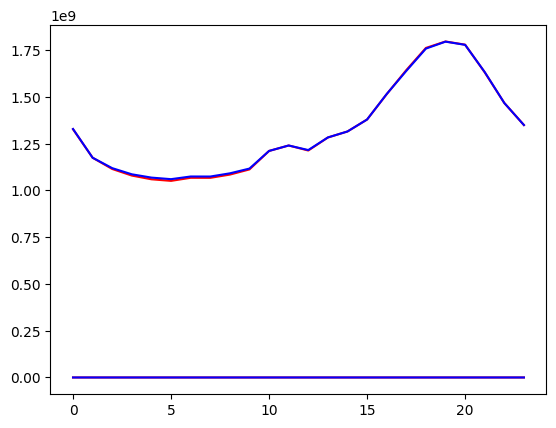

In [24]:
import matplotlib.pyplot as plt
plt.plot(output_ed_only_case_2.cost_generation, c="red") 
plt.plot(output_ed_after_uc.cost_generation, c="blue")

plt.plot(output_ed_only_case_2.marginal_price_generation, c="red")
plt.plot(output_ed_after_uc.marginal_price_generation, c="blue")

**Q2 SNAPSHOT UC**

In [25]:
# the full uc with temporal constraints check
print(output_uc.r.sum()) # checking for reserve although it was set 0 and doesnt matter # it will print 0 cus this formulation somehow does it (the lecture note formulation would have nonzero r)
print(output_uc.total_cost_reserve) # if there were the reserve constraints were not bounding then cost is also 0 so shouldnt affect cost comparison

0.0
0.0


In [26]:
output_uc_snapshot = Output_uc()
solve_uc_snapshot(input_uc, output_uc_snapshot, False)

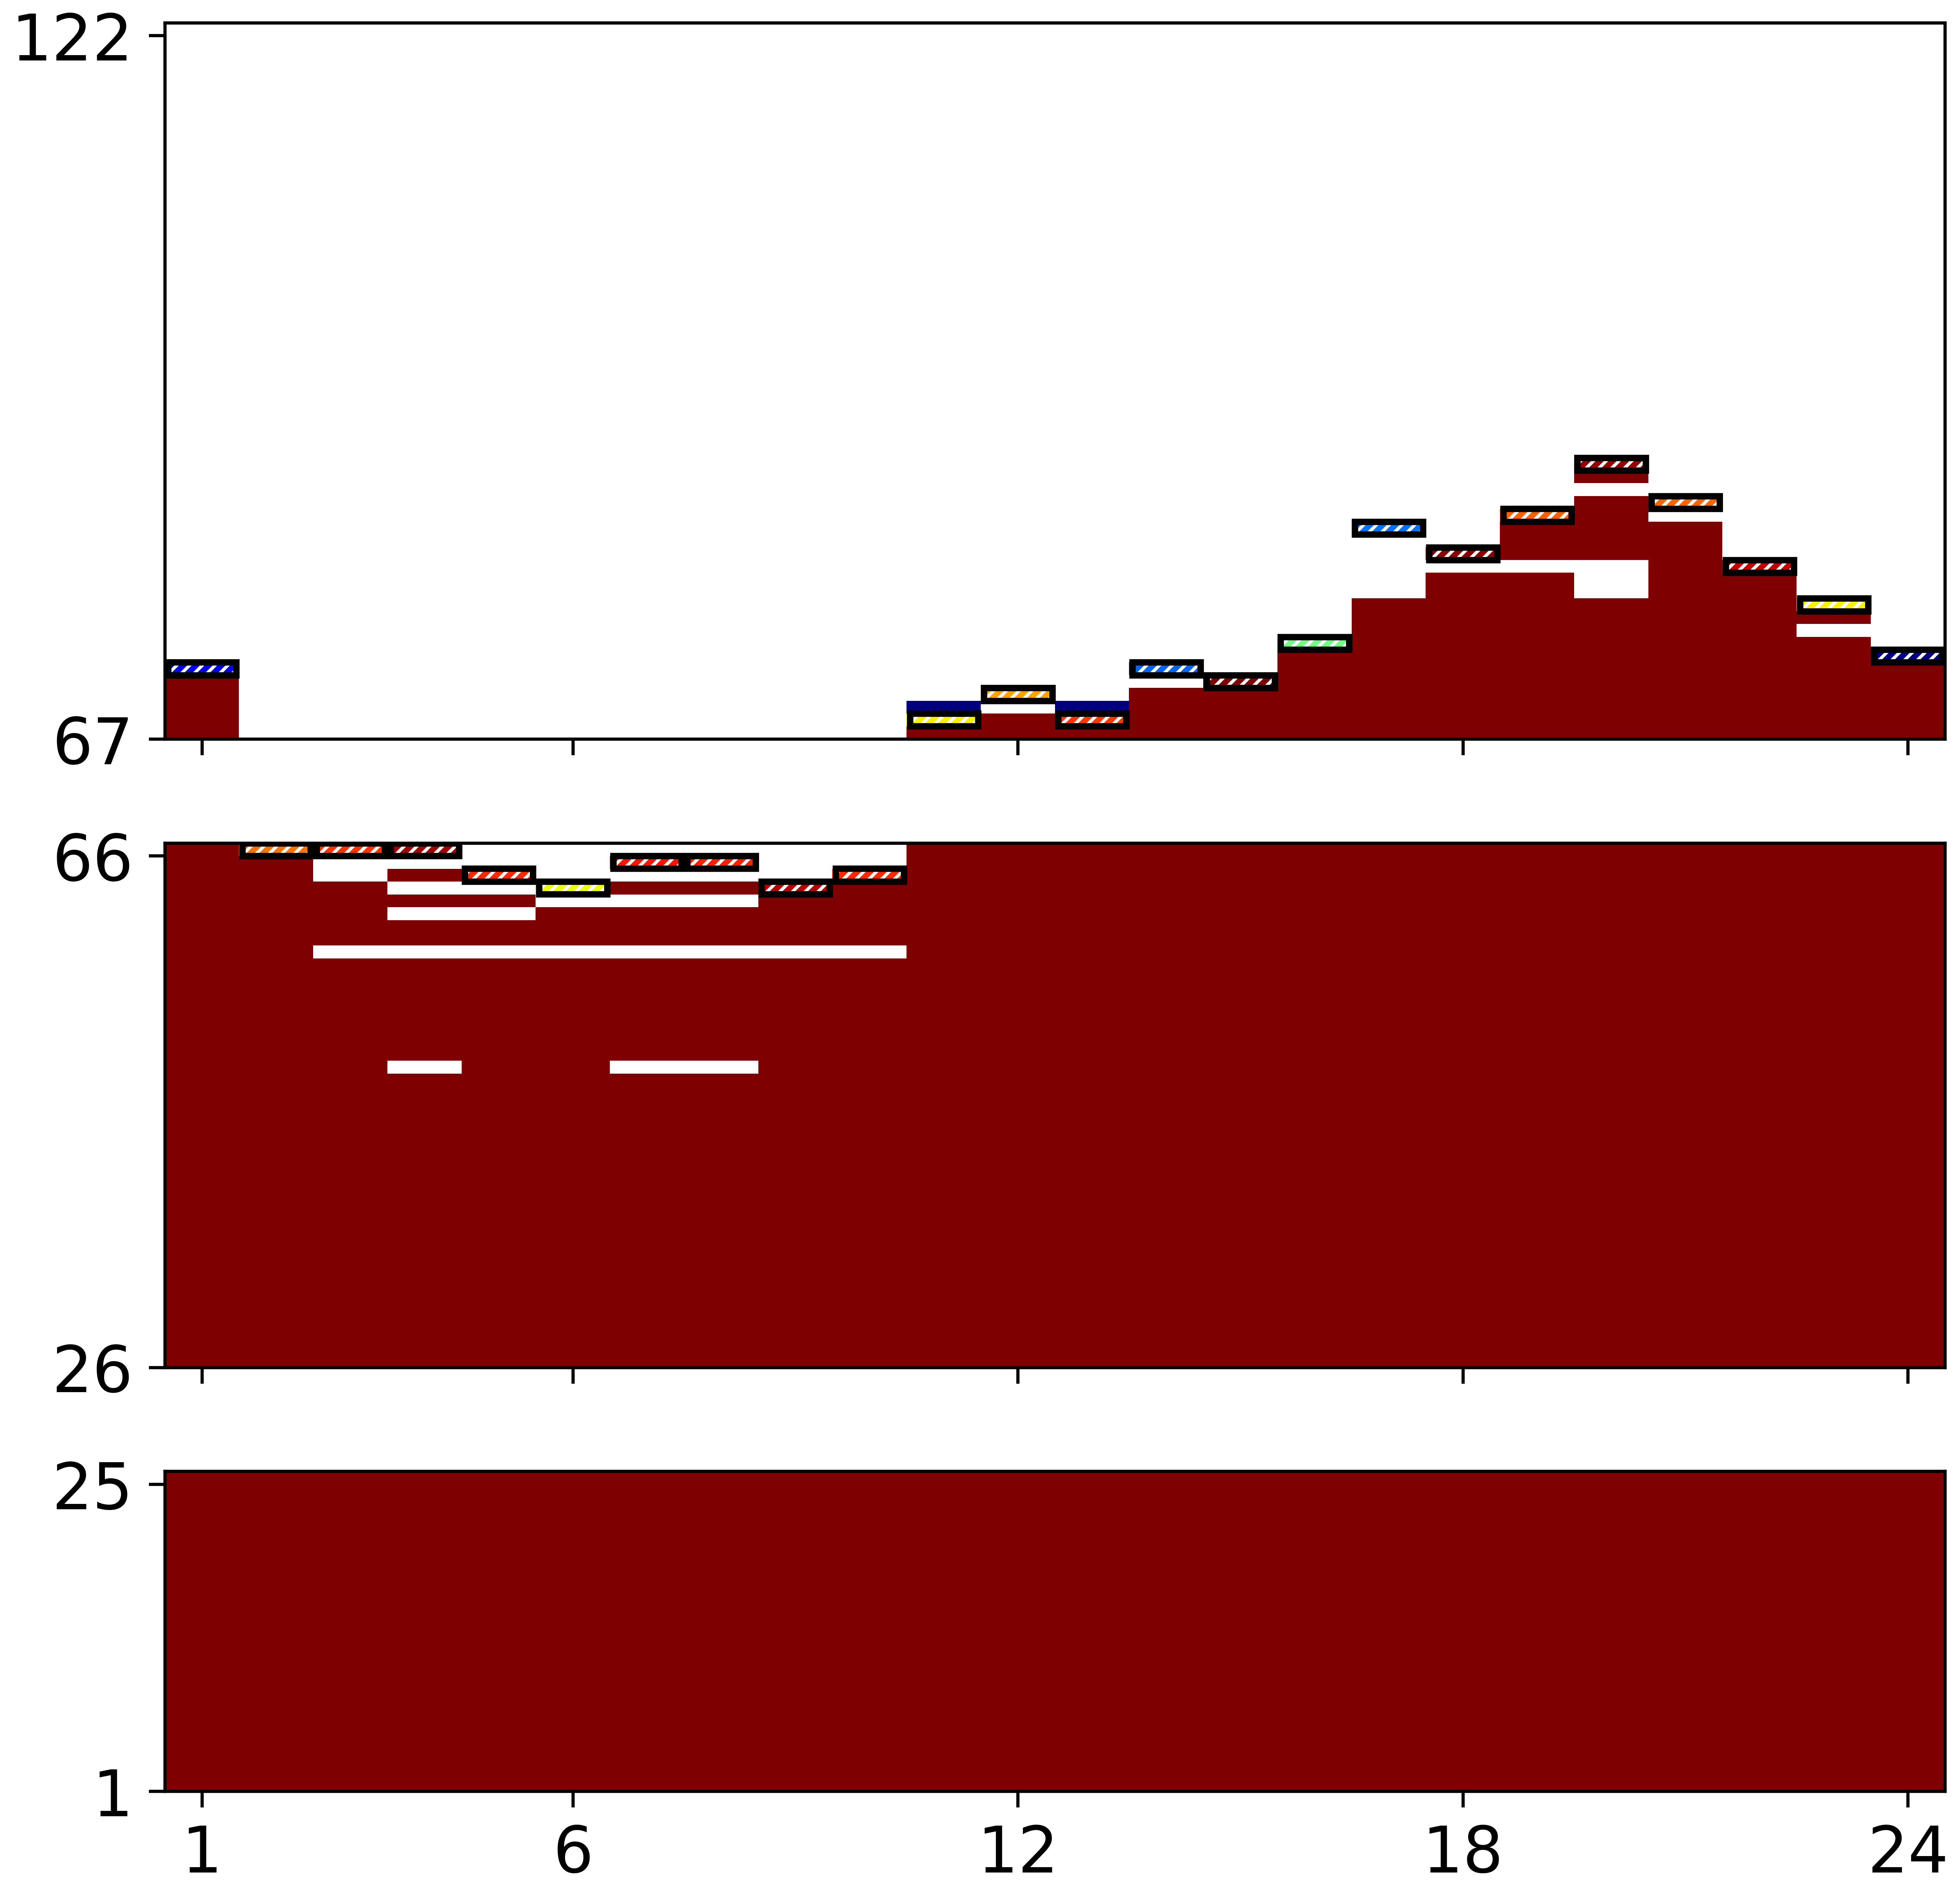

In [27]:
_ = plot_schedule_heatmap(input_uc=input_uc, output_uc=output_uc_snapshot)

In [28]:
output_uc_snapshot.total_cost_generation, float(output_uc.total_cost_generation) # == float(output_ed_after_uc.total_cost_generation)

(31680538217.427876, 31757176600.538876)

In [29]:
output_uc_snapshot.total_cost_generation - float(output_uc.total_cost_generation) # == float(output_ed_after_uc.total_cost_generation)

-76638383.11100006

In [30]:
output_ed_only_case_2.total_cost_generation, float(output_uc.total_cost_generation) # == float(output_ed_after_uc.total_cost_generation)

(np.float64(31705482822.061295), 31757176600.538876)

In [31]:
output_ed_only_case_2.total_cost_generation - float(output_uc.total_cost_generation) # == float(output_ed_after_uc.total_cost_generation)

np.float64(-51693778.477581024)

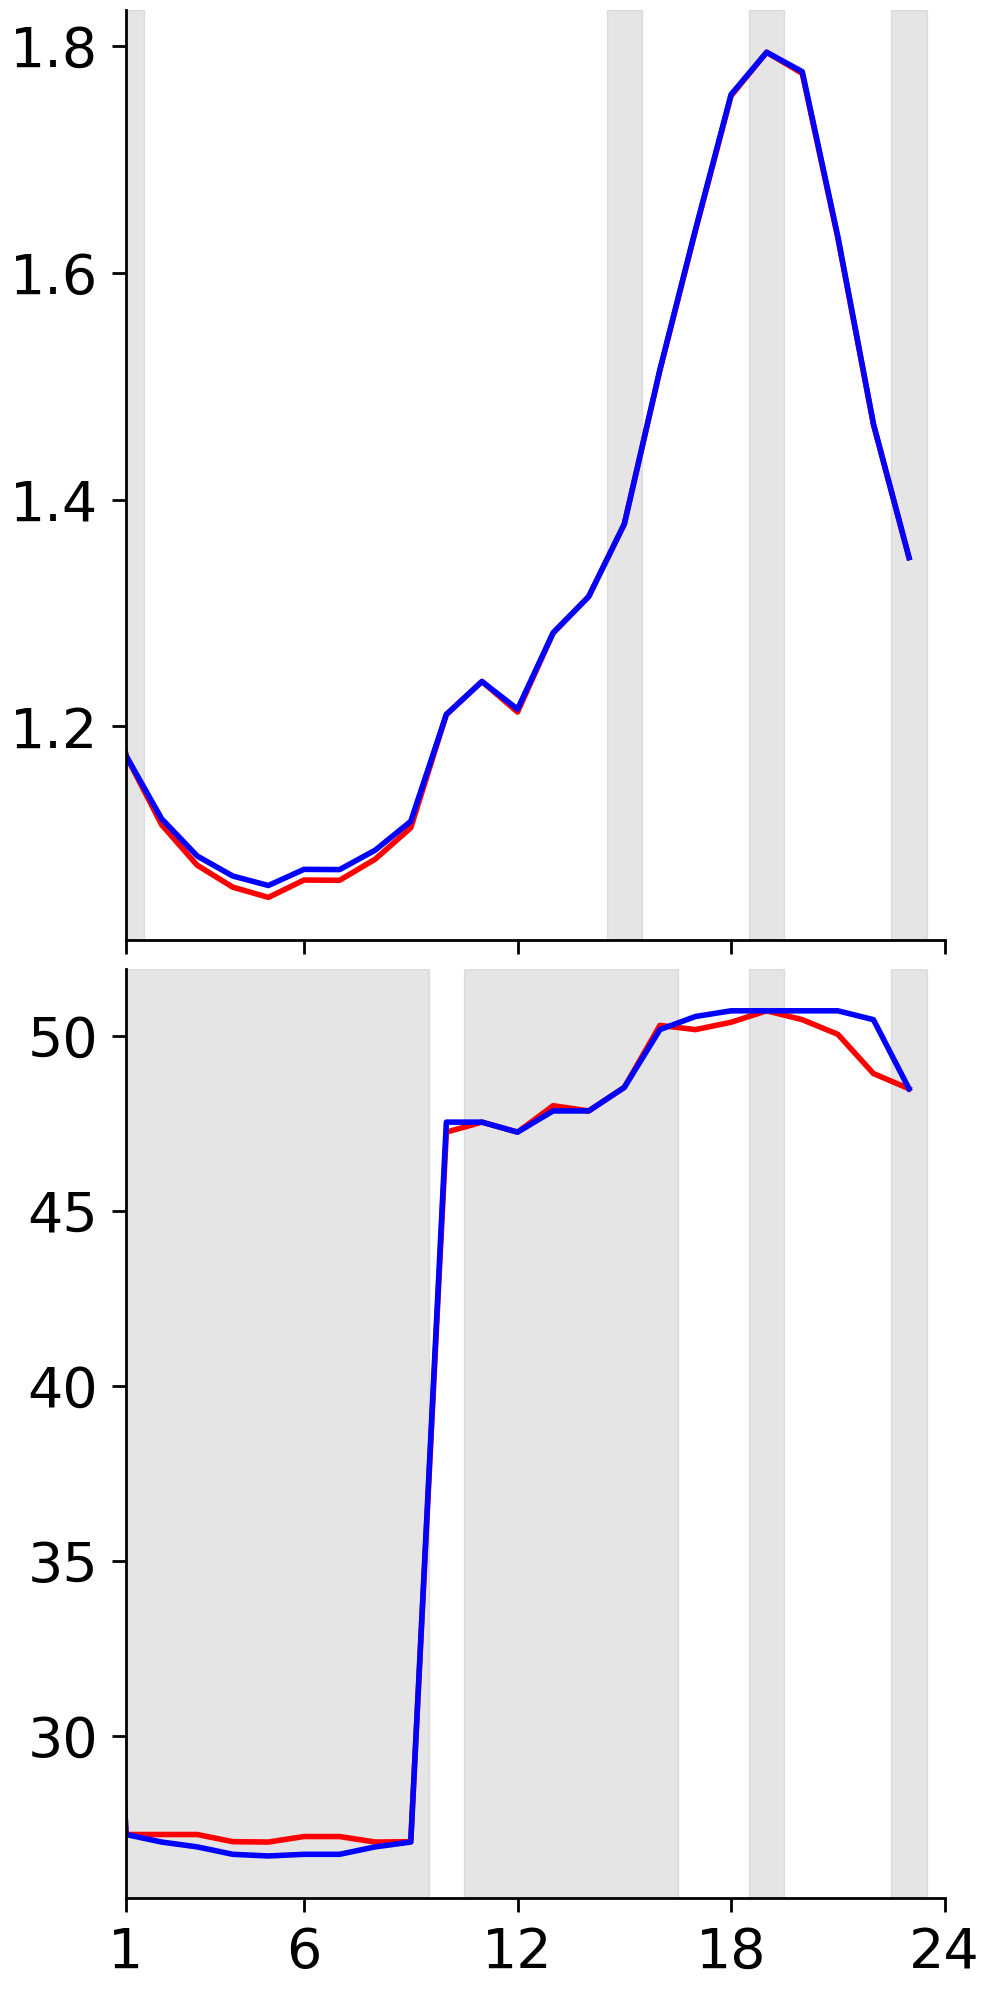

In [32]:
# my slave drew it but i obviously am the king and i know wha tim doing so i told him everything about it
import matplotlib.pyplot as plt
import numpy as np

fig_height = 20
fig_width = 10

fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height), sharex=True)

# Precompute values
gen_cost_red = output_uc_snapshot.cost_generation / 1e9
gen_cost_blue = output_ed_after_uc.cost_generation / 1e9

price_red = output_uc_snapshot.marginal_price_generation / 1e3
price_blue = output_ed_after_uc.marginal_price_generation / 1e3

# Plot: Generation Cost
axes[0].plot(gen_cost_red, c="red", lw=4)
axes[0].plot(gen_cost_blue, c="blue", lw=4)

# Plot: Marginal Price
axes[1].plot(price_red, c="red", lw=4)
axes[1].plot(price_blue, c="blue", lw=4)

# Utility: find contiguous regions where cond is True
def contiguous_regions(cond_array):
    cond_array = np.asarray(cond_array, dtype=bool)
    d = np.diff(cond_array.astype(int))
    starts = np.where(d == 1)[0] + 1
    ends = np.where(d == -1)[0] + 1

    if cond_array[0]:
        starts = np.r_[0, starts]
    if cond_array[-1]:
        ends = np.r_[ends, len(cond_array)]

    return zip(starts, ends)

for start, end in contiguous_regions(gen_cost_red >= gen_cost_blue):
    axes[0].axvspan(start - 0.5, end - 0.5, color="gray", alpha=0.2, edgecolor=None)

for start, end in contiguous_regions(price_red >= price_blue):
    axes[1].axvspan(start - 0.5, end - 0.5, color="gray", alpha=0.2, edgecolor=None)


# Manually add box for hour 1 if it's supposed to be highlighted
if (gen_cost_red[0] >= gen_cost_blue[0]):
    axes[0].axvspan(0.5, 1.5, color="gray", alpha=0.2, edgecolor=None)

if (price_red[0] >= price_blue[0]): # shitpt
    axes[1].axvspan(0.5, 1.4594, color="gray", alpha=0.2, edgecolor=None)

# Design principle application
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for side in ["bottom", "left"]:
        ax.spines[side].set_linewidth(fig_height / 10)

    ax.tick_params(
        axis="both",
        width=fig_height / 10,
        length=fig_height / 2,
        pad=fig_height / 2,
        labelsize=fig_height * 2,
    )

xticks_temp = np.arange(0, num_periods + 1, 6)
xticks_temp[0] = 1
axes[1].set_xticks(xticks_temp)
axes[1].set_xticklabels(xticks_temp)
axes[1].set_xlim(1, 24)

plt.tight_layout()
plt.show()


In [33]:
(output_ed_only_case_2.cost_generation - output_ed_after_uc.cost_generation >= 0).astype(np.int64)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1])

In [34]:
print("SMP shaded hours (red ≥ blue):", np.where(price_red >= price_blue)[0]  + 1)


SMP shaded hours (red ≥ blue): [ 2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 20 24]


In [35]:
axes[1].plot(price_red - price_blue, c="black", lw=2, ls="--")
